In [2]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

In [56]:
import os
import subprocess
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
from _ucrdtw import ucrdtw
from pore_utils.smith_waterman import s_w
sns.set(font_scale=1.5, style="white")
import scipy as sp

In [81]:
def revcomp(seq):
    seq = seq.upper()
    seq = seq.replace("A", "X")
    seq = seq.replace("T", "A")
    seq = seq.replace("X", "T")
    seq = seq.replace("C", "X")
    seq = seq.replace("G", "C")
    seq = seq.replace("X", "G")
    return seq[::-1]


def calculate_dtw(sequences):
    n_seqs = len(sequences)
    D = np.zeros((n_seqs, n_seqs))
    scrappie_dfs = [None for _ in range(n_seqs)]
    squiggles = [None for _ in range(n_seqs)]
    for j in range(n_seqs):
        if scrappie_dfs[j] is None:
            scrappie_dfs[j] = simulate_squiggle(sequences[j])
            squiggles[j] = list(scrappie_dfs[j]["current"])
        for i in range(n_seqs):
            if scrappie_dfs[i] is None:
                scrappie_dfs[i] = simulate_squiggle(sequences[i])
                squiggles[i] = list(scrappie_dfs[i]["current"])
            if i >= j:
                continue
            else:
                dtw_dist = calc_dtw(squiggles[i], squiggles[j])
                D[i, j] = dtw_dist
                D[j, i] = dtw_dist
    return D


def calc_dtw(scrappie_df_1, scrappie_df_2, warp_width=0.1):
    _, dtw_dist = ucrdtw(scrappie_df_1, scrappie_df_2, warp_width, False)
    dtw_dist = np.float32(dtw_dist)
    return dtw_dist


def simulate_squiggle(sequence):
    rand = np.random.randint(0, 500000)
    temp_fasta_fname = sequence + "_" + str(rand) + "_temp.fa"
    temp_scrappie_fname = sequence + "_" + str(rand) + "_temp.scrappie"
    with open(temp_fasta_fname, "w") as f:
        f.write(">temp\n%s\n" % (sequence))    
    scrappie_str = "scrappie squiggle -o %s %s" % (temp_scrappie_fname, temp_fasta_fname)
    os.system(scrappie_str)
    os.remove(temp_fasta_fname)
    
    with open(temp_scrappie_fname, "r") as f:
        scrappie_lines = f.readlines()
    os.remove(temp_scrappie_fname)
    
    scrappie_sim = []
    seq_name = None
    df = None
    for i, line in enumerate(scrappie_lines):
        line = line.strip()
        if line.startswith("#"):
            seq_name = line
        elif line.startswith("pos"):
            continue
        else:
            scrappie_sim.append(line.split("\t"))
    df = pd.DataFrame(scrappie_sim, columns=["pos", "base", "current", "sd", "dwell"])
    df = df.astype({"pos": int, "base": str, "current": float, "sd": float, "dwell": float})
    return df

In [7]:
def calculate_sw(sequences):
    D_sw = np.zeros((96, 96))
    for j in range(96):
        for i in range(96):
            if i >= j:
                continue
            else:
                _, sw, a, _,  _ = s_w(sequences[j], sequences[i], cost_fn={"match": 1, "mismatch": -1, "gap": -8})
                D_sw[i, j] = sw
                D_sw[j, i] = sw
    return D_sw

In [5]:
with open("evolve_from_v3_sw_2adj_seqs.json", "r") as f:
    seqs = json.load(f)

In [10]:
D_sw = calculate_sw(seqs)

In [57]:
D_dtw = calculate_dtw(seqs)

In [11]:
sw_condensed = sp.spatial.distance.squareform(D_sw)
Z = sp.cluster.hierarchy.linkage(sw_condensed, method="weighted")

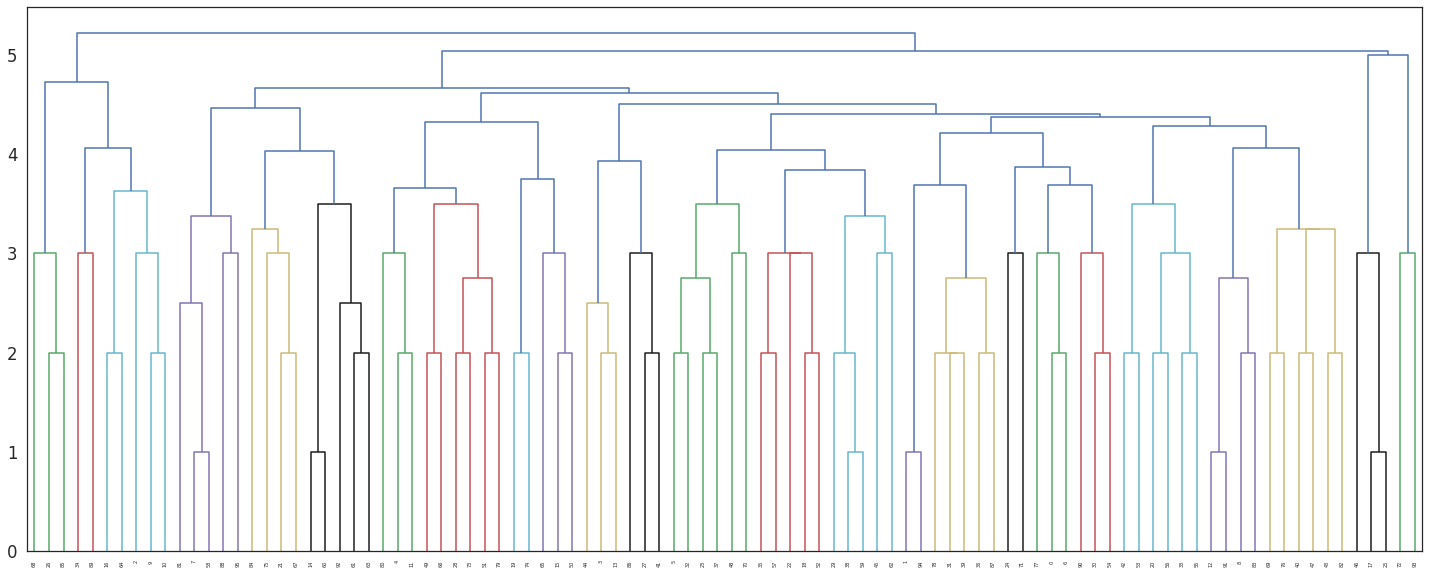

In [12]:
fig = plt.figure(figsize=(25, 10))
dn = sp.cluster.hierarchy.dendrogram(Z)
plt.show()

In [47]:
cluster_init = np.random.choice(range(96), size=6, replace=False)
print (cluster_init)

dist_copy = D_sw.copy()
for i in range(len(dist_copy)):
    for j in range(len(dist_copy)):
        dist_copy[i, j] = np.max(D_sw) - dist_copy[i, j]

for cluster_i in cluster_init:
    dist_copy[:, cluster_i] = 0



nodes_left = set(range(96)) - set(cluster_init)
clusters = [[x] for x in cluster_init]

while(len(nodes_left) > 0):
    print ("\n\n")
    for cluster_i, cluster in enumerate(clusters):
        print ("Cluster:", cluster_i)
        print (np.max(dist_copy[cluster, :]))
#         print dist_copy[cluster, :]
        min_c_dist = np.empty(96)
        min_c_dist.fill(9999)
        for c in cluster:
            min_c_dist = np.minimum(dist_copy[c, :], min_c_dist)

        cluster_to_add = np.argmax(min_c_dist)
        nodes_left.remove(cluster_to_add)
        clusters[cluster_i].append(cluster_to_add)

        dist_copy[:, cluster_to_add] = 0
        

    

[90 35 41 47 48 62]



Cluster: 0
13.0
Cluster: 1
13.0
Cluster: 2
13.0
Cluster: 3
13.0
Cluster: 4
13.0
Cluster: 5
14.0



Cluster: 0
13.0
Cluster: 1
14.0
Cluster: 2
13.0
Cluster: 3
14.0
Cluster: 4
13.0
Cluster: 5
14.0



Cluster: 0
14.0
Cluster: 1
14.0
Cluster: 2
13.0
Cluster: 3
14.0
Cluster: 4
13.0
Cluster: 5
14.0



Cluster: 0
14.0
Cluster: 1
14.0
Cluster: 2
13.0
Cluster: 3
14.0
Cluster: 4
13.0
Cluster: 5
14.0



Cluster: 0
14.0
Cluster: 1
14.0
Cluster: 2
13.0
Cluster: 3
14.0
Cluster: 4
14.0
Cluster: 5
14.0



Cluster: 0
14.0
Cluster: 1
14.0
Cluster: 2
13.0
Cluster: 3
14.0
Cluster: 4
14.0
Cluster: 5
14.0



Cluster: 0
14.0
Cluster: 1
14.0
Cluster: 2
13.0
Cluster: 3
14.0
Cluster: 4
14.0
Cluster: 5
14.0



Cluster: 0
14.0
Cluster: 1
14.0
Cluster: 2
13.0
Cluster: 3
14.0
Cluster: 4
14.0
Cluster: 5
14.0



Cluster: 0
14.0
Cluster: 1
14.0
Cluster: 2
13.0
Cluster: 3
13.0
Cluster: 4
14.0
Cluster: 5
14.0



Cluster: 0
14.0
Cluster: 1
14.0
Cluster: 2
13.0
Cluster: 3
13.0
Cluster: 4
14.0
Cluste

In [48]:
clusters

[[90, 0, 1, 39, 10, 32, 36, 5, 55, 8, 50, 54, 94, 63, 71, 19],
 [35, 25, 52, 57, 2, 37, 67, 82, 6, 77, 87, 14, 34, 53, 45, 86],
 [41, 9, 20, 95, 22, 88, 13, 15, 21, 91, 69, 17, 27, 51, 85, 89],
 [47, 12, 28, 43, 83, 33, 59, 79, 4, 40, 56, 76, 80, 92, 60, 93],
 [48, 31, 11, 3, 61, 73, 78, 44, 81, 49, 65, 74, 46, 16, 72, 58],
 [62, 38, 18, 7, 23, 30, 70, 24, 29, 64, 75, 26, 84, 42, 68, 66]]

Cluster: 0
8.0
3.7421875



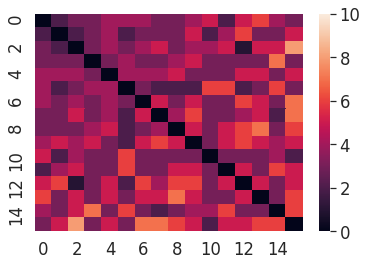

4.455163955688477
5.838004338741302


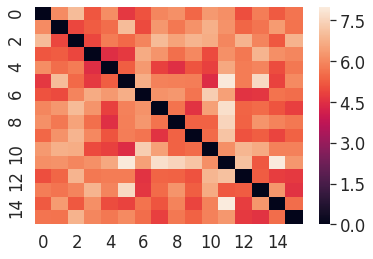

Cluster: 1
8.0
3.6015625



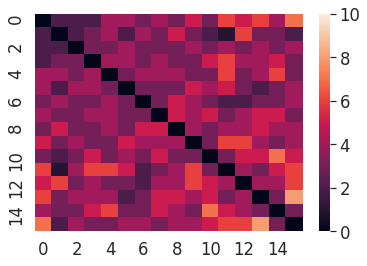

4.4350666999816895
5.788149042924245


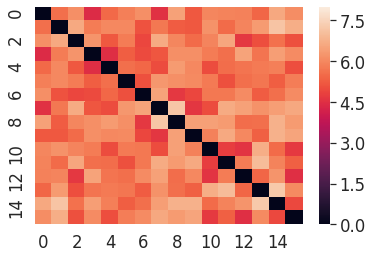

Cluster: 2
7.0
3.78125



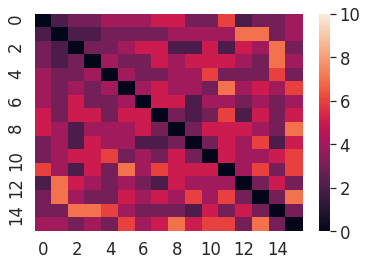

4.369406223297119
5.891412619749705


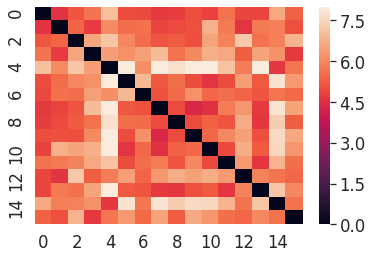

Cluster: 3
8.0
3.40625



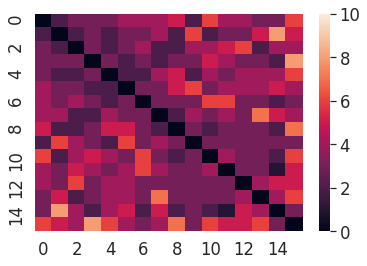

4.4901909828186035
5.782089455922445


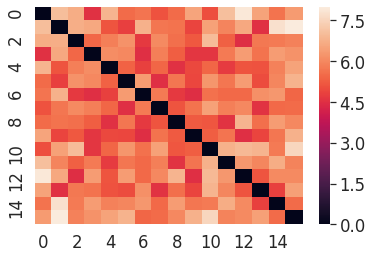

Cluster: 4
9.0
3.9609375



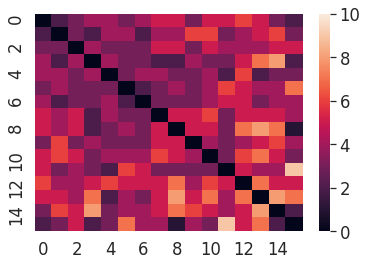

4.416168689727783
6.175568048159281


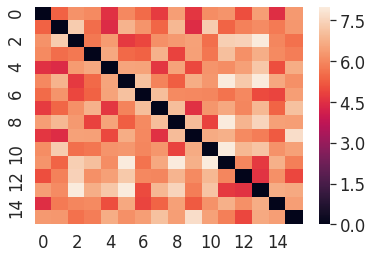

Cluster: 5
9.0
3.828125



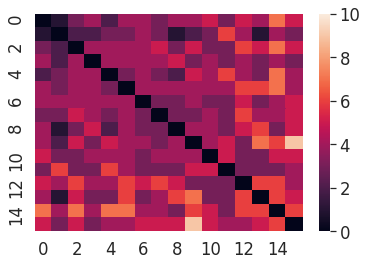

4.455901622772217
5.836424632867177


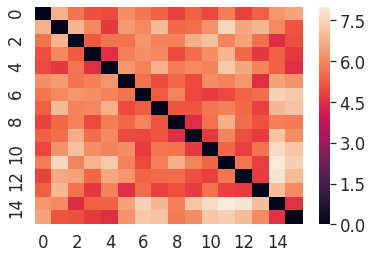

In [61]:
for cluster_i, cluster in enumerate(clusters):
    print("Cluster:", cluster_i)
    
    mini_D_sw = np.zeros((16, 16))
    mini_D_dtw = np.zeros((16, 16))
    mini_dtw_flat = []
    for local_i, i in enumerate(cluster):
        for local_j, j in enumerate(cluster):
            if i == j:
                continue
            sw = D_sw[i, j]
            mini_D_sw[local_i, local_j] = sw
            mini_D_sw[local_j, local_i] = sw
            dtw = D_dtw[i, j]
            mini_D_dtw[local_i, local_j] = dtw
            mini_D_dtw[local_j, local_i] = dtw
            mini_dtw_flat.append(dtw)
    print(np.max(mini_D_sw))
    print(np.mean(mini_D_sw))
    print()
    sns.heatmap(mini_D_sw, vmax=10)
    plt.show()
    print(np.min(mini_dtw_flat))
    print(np.mean(mini_dtw_flat))
    sns.heatmap(mini_D_dtw, vmax=8, vmin=0)
    plt.show()

In [85]:
idt_lines = []
idt_lines.append("Well Position\tSequence Name\tSequence\n")

fasta_lines = []

new_seq_nos = []
orig_seq_nos = []
seq_counter = 0
new_seq_order = []
for cluster_i, cluster in enumerate(clusters):
    col_i =  cluster_i * 2
    cols = [col_i for _ in range(8)]
    cols.extend([col_i + 1 for _ in range(8)])
    locs = ["%s%d" % (r, c) for r, c in list(zip(rows, cols))]
    print(list(locs))

    for local_seq_no, seq_no in enumerate(cluster):
        seq = seqs[seq_no]
        well = locs[local_seq_no]
        seq_no_f = seq[:-4]
        assert len(seq_no_f) == 36
        seq_no_r = revcomp(seq) + "A"
        assert len(seq_no_r) == 41
        
        idt_lines.append("%s\t%d_f\t/5Phos/%s\n" % (well, seq_counter, seq_no_f))
        idt_lines.append("%s\t%d_r\t/5Phos/%s\n" % (well, seq_counter, seq_no_r))
        fasta_lines.append("> %d_f\n%s\n" % (seq_counter, seq))
        new_seq_nos.append(seq_counter)
        orig_seq_nos.append(seq_no)
        new_seq_order.append(seq)
        seq_counter += 1
        
with open("idt_order.tsv", "w") as f:
    for line in idt_lines:
        f.write(line)
with open("idt_order.fa", "w") as fa:
    for line in fasta_lines:
        fa.write(line)

['A0', 'B0', 'C0', 'D0', 'E0', 'F0', 'G0', 'H0', 'A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1']
['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3']
['A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4', 'A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5']
['A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6', 'A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7']
['A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8', 'A9', 'B9', 'C9', 'D9', 'E9', 'F9', 'G9', 'H9']
['A10', 'B10', 'C10', 'D10', 'E10', 'F10', 'G10', 'H10', 'A11', 'B11', 'C11', 'D11', 'E11', 'F11', 'G11', 'H11']


In [83]:
idt_lines

['Well Position\tSequence Name\tSequence\n',
 'A0\t0_f\t/5Phos/TTTATAGAAAACGTTTTGAAGAAGAAGATGATCTCT\n',
 'A0\t0_r\t/5Phos/GAGTAGAGATCATCTTCTTCTTCAAAACGTTTTCTATAAAA\n',
 'B0\t1_f\t/5Phos/TGTCCTACTATGTCTTCTCTCTTCTACTACTTACCT\n',
 'B0\t1_r\t/5Phos/GAGTAGGTAAGTAGTAGAAGAGAGAAGACATAGTAGGACAA\n',
 'C0\t2_f\t/5Phos/GGATGGATGATCCCACACCTCACACGCAGGAGAGAA\n',
 'C0\t2_r\t/5Phos/GAGTTTCTCTCCTGCGTGTGAGGTGTGGGATCATCCATCCA\n',
 'D0\t3_f\t/5Phos/CTAGTGGTAGATGTTGTGTGTGGCGCGAGAGAAAGC\n',
 'D0\t3_r\t/5Phos/GAGTGCTTTCTCTCGCGCCACACACAACATCTACCACTAGA\n',
 'E0\t4_f\t/5Phos/TTGCGACGATGACTGACGACTGCACGAAAAGCTGGA\n',
 'E0\t4_r\t/5Phos/GAGTTCCAGCTTTTCGTGCAGTCGTCAGTCATCGTCGCAAA\n',
 'F0\t5_f\t/5Phos/GTGAGGAGGAGAAGTAAAAGAAAGCTTCGAGAGAGT\n',
 'F0\t5_r\t/5Phos/GAGTACTCTCTCGAAGCTTTCTTTTACTTCTCCTCCTCACA\n',
 'G0\t6_f\t/5Phos/AGTTTACACGGCGCTCTTTCCGGTTTGATCTTGCAC\n',
 'G0\t6_r\t/5Phos/GAGTGTGCAAGATCAAACCGGAAAGAGCGCCGTGTAAACTA\n',
 'H0\t7_f\t/5Phos/CTGTTTGCACACACACCCGCACACCCTGTTCCCTCG\n',
 'H0\t7_r\t/5Phos/GAGTCGAGGGAACAGGG